# Value-at-Risk

In [27]:
# Import pandas & yfinance
# Import numpy
from collections import OrderedDict
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import yfinance as yf
from numpy.linalg import multi_dot
from scipy import stats
from tabulate import tabulate

# Set numpy random seed
np.random.seed(23)

In [2]:
import cufflinks as cf

cf.set_config_file(offline=True, theme="solar", dimensions=((1000, 600)))
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = pio.templates["plotly_dark"]

px.defaults.width, px.defaults.height = 1000, 600

In [3]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [6]:
# Retrive data

In [8]:
# Read from file
df = pd.read_csv("data/india_stocks.csv", index_col=0, parse_dates=True)
# Display dataframe
df

,ASIANPAINT,HDFCBANK,ITC,RELIANCE,TCS
Date,,,,,
2015-01-01 00:00:00+05:30,704.9195,446.3565,191.1795,417.9889,1065.1387
2015-01-02 00:00:00+05:30,729.2903,452.5686,191.7784,416.8826,1079.3236
2015-01-05 00:00:00+05:30,729.2432,448.7476,192.5334,412.3163,1062.9208
2015-01-06 00:00:00+05:30,711.8356,441.7619,187.5866,393.6035,1023.7350
2015-01-07 00:00:00+05:30,726.1381,443.0511,184.0978,402.1714,1011.6425
...,...,...,...,...,...
2022-12-26 00:00:00+05:30,3035.8335,1610.9755,327.3880,2524.0500,3156.5701
2022-12-27 00:00:00+05:30,3092.0093,1612.6068,325.9692,2544.7000,3162.9751
2022-12-28 00:00:00+05:30,3103.0359,1611.3215,327.1923,2544.4500,3160.6460


In [9]:
# Calculate daily returns
returns = df.pct_change().dropna()
returns.head()

,ASIANPAINT,HDFCBANK,ITC,RELIANCE,TCS
Date,,,,,
2015-01-02 00:00:00+05:30,3.4572e-02,0.0139,0.0031,-0.0026,0.0133
2015-01-05 00:00:00+05:30,-6.4526e-05,-0.0084,0.0039,-0.0110,-0.0152
2015-01-06 00:00:00+05:30,-2.3871e-02,-0.0156,-0.0257,-0.0454,-0.0369
2015-01-07 00:00:00+05:30,2.0092e-02,0.0029,-0.0186,0.0218,-0.0118
2015-01-08 00:00:00+05:30,6.3043e-02,0.0210,0.0250,-0.0143,0.0108


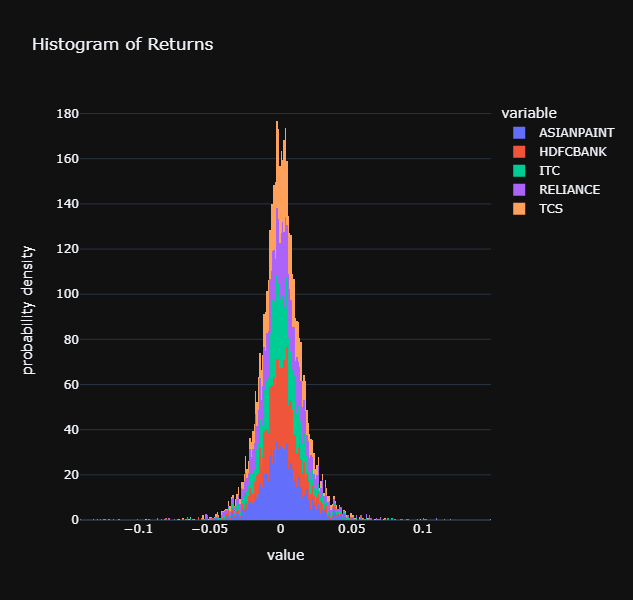

In [10]:
# Plot histogram
px.histogram(
    returns,
    histnorm="probability density",
    title="Histogram of Returns",
    barmode="relative",
)

## Parametric VaR

In [15]:
# Stock returns
stockreturn = returns["HDFCBANK"]
# Calculate mean and standard deviation
mean = np.mean(stockreturn)
stdev = np.std(stockreturn)
# Calculate VaR at difference confidence level
VaR_90 = stats.norm.ppf(1 - 0.90, mean, stdev)
VaR_95 = stats.norm.ppf(1 - 0.95, mean, stdev)
VaR_99 = stats.norm.ppf(1 - 0.99, mean, stdev)

In [16]:
# number of stdev from the mean
stats.norm.ppf(0.01)

-2.3263478740408408

In [19]:
# Ouput results in tabular format
table = [["90%", VaR_90], ["95%", VaR_95], ["99%", VaR_99]]
header = ["Confidence Level", "Value At Risk"]
print(tabulate(table, headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0181096
95%                      -0.0234583
99%                      -0.0334916


### Normality Test

In [21]:
# normality test
stats.shapiro(stockreturn)

ShapiroResult(statistic=0.9051830172538757, pvalue=2.3060265937385995e-33)

In [22]:
# normality test
stats.anderson(stockreturn)

AndersonResult(statistic=27.42583440424505, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0007580403572462423, scale=0.014726216962560525)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

## Modified VaR

In [28]:
# First four moments
dist = OrderedDict(
    {
        "Mean": np.mean(returns["HDFCBANK"]),
        "Variance": np.std(returns["HDFCBANK"]),
        "Skew": stats.skew(returns["HDFCBANK"]),
        "Kurtosis": stats.kurtosis(returns["HDFCBANK"]),
    }
)
pprint(dist)

OrderedDict([('Mean', 0.0007580403572462423),
             ('Variance', 0.014722488334329455),
             ('Skew', 0.07119713990370992),
             ('Kurtosis', 10.459960714252444)])


In [46]:
# Specify params for modified var
z = abs(stats.norm.ppf(0.01))
s = stats.skew(stockreturn)
k = stats.kurtosis(stockreturn)
t = (
    z
    + 1 / 6 * (z**2 - 1) * s
    + 1 / 24 * (z**3 - 3 * z) * k
    - 1 / 36 * (2 * z**3 - 5 * z) * s**2
)
# Calculate VaR at difference confidence level
mVaR_99 = mean - t * stdev
mVaR_99

-0.07023678761478336

In [ ]:
# # Ouput results in tabular format
# mtable = [["90%", mVaR_90], ["95%", mVaR_95], ["99%", mVaR_99]]
# print(tabulate(mtable, headers=header))

## Historical VaR

In [31]:
# Use quantile function for Historical VaR
hVaR_90 = returns["HDFCBANK"].quantile(0.10)
hVaR_95 = returns["HDFCBANK"].quantile(0.05)
hVaR_99 = returns["HDFCBANK"].quantile(0.01)

In [32]:
# Ouput results in tabular format
htable = [["90%", hVaR_90], ["95%", hVaR_95], ["99%", hVaR_99]]
print(tabulate(htable, headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0141972
95%                      -0.0199751
99%                      -0.0364953


## MonteCarlo VaR

In [34]:
# Set seed for reproducibility
np.random.seed(42)
# Number of simulations
n_sims = 5000
# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)
# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns, 10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

In [35]:
# Ouput results in tabular format
mctable = [["90%", MCVaR_90], ["95%", MCVaR_95], ["99%", MCVaR_99]]
print(tabulate(mctable, headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0179306
95%                      -0.0229988
99%                      -0.0340315


## Scaling VaR

In [37]:
# VaR Scaling
forecast_days = 5
f_VaR_90 = VaR_90 * np.sqrt(forecast_days)
f_VaR_95 = VaR_95 * np.sqrt(forecast_days)
f_VaR_99 = VaR_99 * np.sqrt(forecast_days)

In [38]:
# Ouput results in tabular format
ftable = [["90%", f_VaR_90], ["95%", f_VaR_95], ["99%", f_VaR_99]]
fheader = ["Confidence Level", "5-Day Forecast Value At Risk"]
print(tabulate(ftable, headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0404943
95%                                     -0.0524543
99%                                     -0.0748895


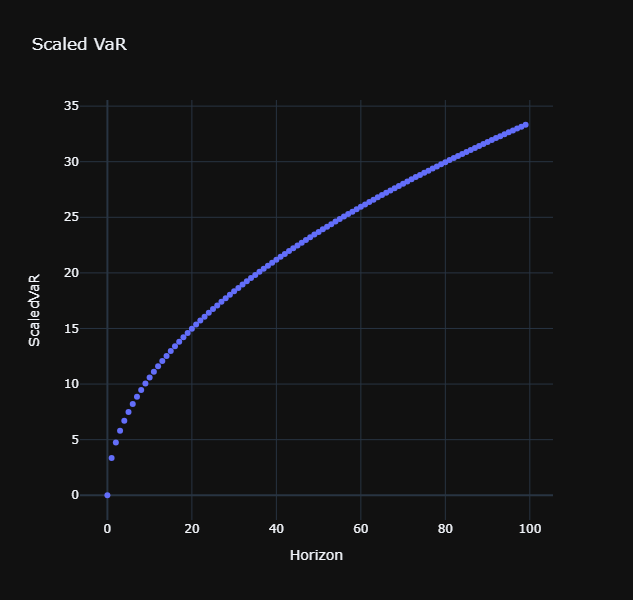

In [41]:
# Plot Scaled VaR
sVaR = pd.DataFrame(
    [-100 * VaR_99 * np.sqrt(x) for x in range(100)], columns=["ScaledVaR"]
)
px.scatter(
    sVaR,
    sVaR.index,
    "ScaledVaR",
    title="Scaled VaR",
    labels={"index": "Horizon"},
)

## Expected Short Fall

In [42]:
# Calculate CVar
CVaR_90 = returns['HDFCBANK'][returns['HDFCBANK']<=hVaR_90].mean()
CVaR_95 = returns['HDFCBANK'][returns['HDFCBANK']<=hVaR_95].mean()
CVaR_99 = returns['HDFCBANK'][returns['HDFCBANK']<=hVaR_99].mean()

In [43]:
# Ouput results in tabular format
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0242577
95%                                  -0.0319729
99%                                  -0.0560803


## Portfolio VaR

In [45]:
# Weights from Minimum Variance Portfolio
wts = np.array([1.928e-01, 2.367e-01, 2.099e-01, 7.286e-02, 2.878e-01])
# Portfolio mean returns and volatility
port_mean = wts.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
pVaR = stats.norm.ppf(1-0.99, port_mean, port_stdev)
print(f"Mean: {port_mean}, Stdev: {port_stdev}, pVaR: {pVaR}")

Mean: 0.0007072635371097425, Stdev: 0.010385537178319183, pVaR: -0.0234531087984452
